## Assign the rat's x,y position to the corresponding hex

Here we do this directly from position/centroids in the nwbfile, but ultimately we will use the position table and HexMazeBlock schema in spyglass

TODO: Save the assigned hex position in a new table/schema

In [ ]:
import spyglass.data_import as sgi
import spyglass.common as sgc
from spyglass.common import Nwbfile
from pynwb import NWBHDF5IO
import math
import pandas as pd
import numpy as np

# Specify nwbfile name and position series to use for hex assignment
#nwb_file_name = "BraveLu20240516_.nwb"
#name_of_position_series = 'led_0_series_1'
nwb_file_name = "IM-1478_20220725_.nwb"
name_of_position_series = "cap_front_position"

def get_side_hex_centroids(hex_centroids):
    def find_4th_hex_centroid_parallelogram(top_hex, middle_hex, bottom_hex):
        """ 
        Helper function used for finding centroids of the side half-hexes by reward ports.
        
        Given 3 (x,y) hex centroids top_hex, middle_hex, and bottom_hex, find the 
        4th hex centroid such that the 4 hexes are arranged in a parallelogram.
        
        For example, to find the centroid of the side hex to the left of hex 4
        (when facing the reward port), top_hex=1, middle_hex=4, bottom_hex=6.
        
        Note that 'top' and 'bottom' are relative and interchangeable - generally, I set
        the 'top' hex as one of the reward ports. (it doesn't have to be 'top' and 'bottom' 
        in an x,y coordinate sense, just 'middle' needs to be the hex between them)
        """
        other_middle_hex = np.array(top_hex) + (np.array(bottom_hex) - np.array(middle_hex))
        return tuple(other_middle_hex)

    # Calculate the centroids of the 6 side half-hexes next to the reward ports
    hex4left = find_4th_hex_centroid_parallelogram(hex_centroids[1], hex_centroids[4], hex_centroids[6])
    hex4right = find_4th_hex_centroid_parallelogram(hex_centroids[1], hex_centroids[4], hex_centroids[5])
    hex49left = find_4th_hex_centroid_parallelogram(hex_centroids[2], hex_centroids[49], hex_centroids[47])
    hex49right = find_4th_hex_centroid_parallelogram(hex_centroids[2], hex_centroids[49], hex_centroids[38])
    hex48left = find_4th_hex_centroid_parallelogram(hex_centroids[3], hex_centroids[48], hex_centroids[33])
    hex48right = find_4th_hex_centroid_parallelogram(hex_centroids[3], hex_centroids[48], hex_centroids[43])
    # Return a dict of side hex centroids
    return {"4_left": hex4left, "4_right": hex4right, "49_left": hex49left, "49_right": hex49right, 
            "48_left": hex48left, "48_right": hex48right}

def euclidean_distance(coord1, coord2):
    """ Calculate Euclidean distance between two coordinates """
    return math.sqrt((coord1[0] - coord2[0]) ** 2 + (coord1[1] - coord2[1]) ** 2)

def assign_to_hex(x_list, y_list, hex_centroids):
    """ 
    Assign each (x, y) coordinate to the nearest hex centroid in hex_centroids.
    
    Make sure the rat's x, y coordinates and the centroids in hex_centroids
    are in the same units (both in pixels or both in cm/meters) !!
    
    Args:
    x_list (list): List of the rat's x coordinates
    y_list (list): List of the rat's y coordinates
    hex_centroids (dict): Dictionary of hex: (x, y) centroid
    
    Returns: 
    List of hexes the same length as x_list and y_list indicating which hex
    this point has been assigned to
    """
    
    # Check that we have the same length x and y
    if len(x_list) != len(y_list):
        raise ValueError("x_list and y_list must have the same length.")
    
    coordinates_list = list(zip(x_list, y_list))
    hex_list = []

    for coord in coordinates_list:
        min_distance = float('inf')
        closest_hex = np.nan

        # Loop through all of the hexes to find which one is the closest
        for hex, hex_coords in hex_centroids.items():
            distance_from_hex = euclidean_distance(coord, hex_coords)
            if distance_from_hex < min_distance:
                min_distance = distance_from_hex
                closest_hex = hex
        
        hex_list.append(closest_hex)
    
    return hex_list

nwb_file_path = Nwbfile().get_abs_path(nwb_file_name)
with NWBHDF5IO(nwb_file_path, mode="r") as io:
    nwbfile = io.read()
    behavior_module = nwbfile.processing["behavior"]

    # Get hex centroids and convert to a dict of hex: (x, y)
    centroids_df = behavior_module.data_interfaces["hex_centroids"].to_dataframe()
    centroids_dict = centroids_df.set_index('hex')[['x', 'y']].apply(tuple, axis=1).to_dict()
    
    # Calculate and add centroids of side hexes
    side_centroids_dict = get_side_hex_centroids(centroids_dict)
    all_centroids_dict = {**centroids_dict , **side_centroids_dict}
    print(all_centroids_dict)

    # Get position data (we may have multiple spatial series, so choose the name)
    position = behavior_module.data_interfaces["position"].spatial_series[name_of_position_series]
    position_df = pd.DataFrame(position.data, columns=["x", "y"]) 
    position_df["timestamp"] = position.timestamps
    position_df["hex"] = np.nan

    # Get block data
    block_data = nwbfile.intervals["block"].to_dataframe()
    for block in block_data.itertuples(index=False):
        # Get barrier locations for this block (convert to list of ints)
        barriers = [int(hex) for hex in block.maze_configuration.split(",")]
        
        # Get the centroids of open hexes for this block (remove hexes that are barriers)
        hex_centroids_block = {hex: coords for hex, coords in all_centroids_dict.items() if hex not in barriers}
        
        # Get position indices for the current block
        block_mask = (position_df["timestamp"] >= block.start_time) & (position_df["timestamp"] <= block.stop_time)

        # Assign each x, y position in this block to a hex 
        position_df.loc[block_mask, "hex"] = assign_to_hex(position_df.loc[block_mask, 'x'], 
                                                           position_df.loc[block_mask, 'y'], 
                                                           hex_centroids_block)

{1.0: (324.0, 55.0), 4.0: (326.0, 95.0), 6.0: (291.0, 111.0), 5.0: (359.0, 113.0), 8.0: (293.0, 151.0), 7.0: (359.0, 152.0), 11.0: (251.0, 170.0), 10.0: (324.0, 171.0), 9.0: (391.0, 172.0), 14.0: (249.0, 205.0), 13.0: (323.0, 208.0), 12.0: (391.0, 208.0), 18.0: (226.0, 227.0), 17.0: (291.0, 228.0), 16.0: (358.0, 228.0), 15.0: (427.0, 232.0), 22.0: (222.0, 266.0), 21.0: (290.0, 264.0), 20.0: (356.0, 267.0), 19.0: (426.0, 266.0), 27.0: (191.0, 287.0), 26.0: (256.0, 285.0), 25.0: (323.0, 285.0), 24.0: (388.0, 287.0), 23.0: (458.0, 288.0), 32.0: (188.0, 323.0), 31.0: (255.0, 322.0), 30.0: (322.0, 321.0), 29.0: (390.0, 319.0), 28.0: (462.0, 326.0), 38.0: (157.0, 345.0), 37.0: (226.0, 344.0), 36.0: (292.0, 344.0), 35.0: (358.0, 343.0), 34.0: (425.0, 347.0), 33.0: (492.0, 349.0), 49.0: (154.0, 380.0), 42.0: (223.0, 380.0), 41.0: (293.0, 381.0), 40.0: (358.0, 381.0), 39.0: (427.0, 387.0), 48.0: (497.0, 386.0), 2.0: (125.0, 399.0), 47.0: (190.0, 402.0), 46.0: (258.0, 402.0), 45.0: (323.0, 403.0

/tmp/ipykernel_2857815/3220047543.py:117: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, nan, nan, nan, nan, nan, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 10.0, nan, nan, nan, nan, nan, nan, 6.0, 6.0, 8.0, 8.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, nan, nan, nan, 24.0, 24.0, 24.0, nan, 24.0, 19.0, 19.0, 19.0, 19.0, 19.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 20.0, 20.0, 20.0,

### Sanity check of assigning the rat's position to a hex

- Create a scatterplot of the rat's position overlayed on the hex grid
- Color the rat's position based on the assigned hex

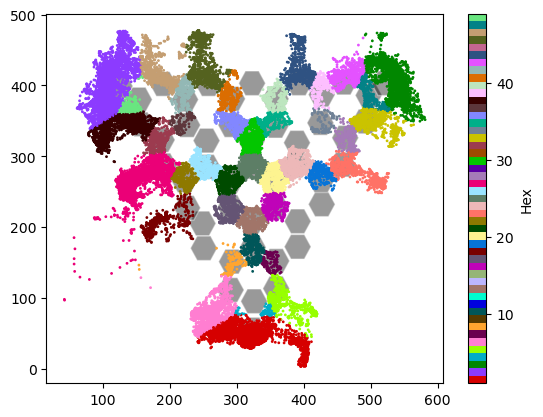

In [11]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap
import math
import colorcet as cc

# Get a colormap of 49 distinct colors so we can color by hex
hex_colormap = ListedColormap(cc.glasbey[:49])

# Plot hexes using the centroids dict from the nwbfile
fig, ax = plt.subplots()
for (x, y) in centroids_dict.values():
    hexagon = patches.RegularPolygon(
        (x, y),
        numVertices=6,
        radius=20, # TODO: replace this with calculated value based on hex spacing
        orientation=math.pi/6,
        edgecolor='white',
        facecolor='black',
        alpha=0.4
    )
    ax.add_patch(hexagon)

# Plot scatter of rat position colored by assigned hex
rat_position = ax.scatter(
    position_df.x,
    position_df.y,
    c=position_df.hex,          
    cmap=hex_colormap,
    s=1
)
cbar = plt.colorbar(rat_position, ax=ax)
cbar.set_label('Hex')
plt.show()

In [ ]:
# Starting hex assignment from spyglass... 
# abandoned bc of checksum issues for now but will come back hehe
import spyglass.data_import as sgi
import spyglass.common as sgc
from spyglass.common import Nwbfile
from hex_maze_behavior import HexMazeConfig, HexMazeBlock
from pynwb import NWBHDF5IO

nwb_file_name = "BraveLu20240519_.nwb"
interval_list_name = "pos 1 valid times"
sgc.Session & {"nwb_file_name": nwb_file_name}

# Get position from schema
raw_position_df = (sgc.RawPosition() 
                   & {"nwb_file_name": nwb_file_name, 
                      "interval_list_name": interval_list_name}
                   ).fetch1_dataframe()
display(raw_position_df)

# Get block info from block table
block = (HexMazeBlock() & {"nwb_file_name": nwb_file_name})
display(block)

# Open nwbfile to get centroids!
nwb_file_path = Nwbfile().get_abs_path(nwb_file_name)
with NWBHDF5IO(nwb_file_path, 'r') as io:
    nwbfile = io.read()
    behavior_module = nwbfile.processing["behavior"]

    # Get hex centroids and convert to a dict of hex: (x, y)
    centroids_df = behavior_module.data_interfaces["hex_centroids"].to_dataframe()
    centroids_dict = centroids_df.set_index('hex')[['x', 'y']].apply(tuple, axis=1).to_dict()

print(centroids_dict)


# TODO: concatenate all interval lists into a big list, 
# then get the block time bounds and maze config from hexmazeblock,
# then do hex assignment by block!

#  # Get block data
#  block_data = nwbfile.intervals["block"].to_dataframe()
#  for block in block_data.itertuples(index=False):
#      # Get barrier locations for this block (convert to list of ints)
#      barriers = [int(hex) for hex in block.maze_configuration.split(",")]
      
#      # Get the centroids of open hexes for this block (remove hexes that are barriers)
#      hex_centroids_block = {hex: coords for hex, coords in centroids_dict.items() if hex not in barriers}
      
#      # Get position indices for the current block
#      block_mask = (position_df["timestamp"] >= block.start_time) & (position_df["timestamp"] <= block.stop_time)

#      # Assign each x, y position in this block to a hex 
#      position_df.loc[block_mask, "hex"] = assign_to_hex(position_df.loc[block_mask, 'x'], 
#                                                         position_df.loc[block_mask, 'y'], 
#                                                         hex_centroids_block)


#  display(position_df)

In [ ]:
# How to get processed position for hex assignment?

# Things we need.
# nwb_file_name
# interval_list_name: pos {epoch} valid times - this is the epoch from the block table! ALWAYS true <3

# user chooses 'trodes_pos_params_name' for however they wanna process raw position data

# Get conversion factor of pixels to meters from raw position 
# (this is 100% populated by insert session - fully automatable!!!!!! YAY)
raw_position = (sgc.RawPosition.PosObject & {"nwb_file_name": nwb_copy_file_name, 'interval_list_name':interval_list_name})
spatial_series = raw_position.fetch_nwb()[0]["raw_position"]
conversion_factor = spatial_series.conversion
conversion_unit = spatial_series.unit

# How the user does raw position (also see Xulu's notebook):

# Step 1. Insert position_key into TrodesPosSelection table
position_key = {
    "nwb_file_name": nwb_copy_file_name,
    "interval_list_name": interval_list_name,
    "trodes_pos_params_name": trodes_params_name,
}
sgp.v1.TrodesPosSelection.insert1(
    position_key,
    skip_duplicates=True,
)

# Step 2. Use this position_key to populate TrodesPosV1
sgp.v1.TrodesPosV1.populate(position_key)

# When we populatethe `TrodesPosV1` table, we automatically create an entry in the `PositionOutput` merge table.  
# This is where we want to access the data from 

# Step 3. Get the merge id corresponding to our inserted position_key
merge_key = (PositionOutput.merge_get_part(position_key)).fetch1("KEY")
# Use this to restrict PositionOutput and fetch the data
position_info = (PositionOutput & merge_key).fetch1_dataframe()


